# Librairies 

In [1]:
import tensorflow as tf
print(tf.__version__)

2022-02-10 14:29:22.449341: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 14:29:22.449380: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.8.0


In [2]:
# paramétrage de l'environnement pour python3 :
#import pandas as pd

import sys
# rebuild tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from os import listdir

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import boto3
import io

from PIL import Image

import timeit



In [3]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
import keras

from sklearn import manifold, decomposition
import numpy as np

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


# Code

### Initialisation, création Session Spark :

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[1]").appName("FruitsP8").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/10 14:29:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [85]:
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("miniProject").setMaster("local[*]")
sc = SparkContext.getOrCreate(conf)

sc.setLogLevel("ERROR")


### Création de la liste des fruits :

In [7]:
client = boto3.client('s3')
s3 = boto3.resource('s3')
bucket_name = "donneesp8v2"

In [8]:
objects_dict = client.list_objects(Bucket=bucket_name, Prefix='fruits-360')

In [9]:
#s3_keys = [item['Key'] for item in objects_dict['Contents'] if item['Key'].endswith('.parquet')]

s3_keys = [item['Key'] for item in objects_dict['Contents']]
s3_keys


['fruits-360/Apple Crimson Snow/0_100.jpg',
 'fruits-360/Apple Crimson Snow/10_100.jpg',
 'fruits-360/Apple Crimson Snow/111_100.jpg',
 'fruits-360/Apple Golden 2/0_100.jpg',
 'fruits-360/Apple Golden 2/100_100.jpg',
 'fruits-360/Apple Golden 2/101_100.jpg',
 'fruits-360/Apple Granny Smith/0_100.jpg',
 'fruits-360/Apple Granny Smith/100_100.jpg',
 'fruits-360/Apple Granny Smith/101_100.jpg',
 'fruits-360/Apple Red 1/0_100.jpg',
 'fruits-360/Apple Red 1/100_100.jpg',
 'fruits-360/Apple Red 1/101_100.jpg',
 'fruits-360/Apple Red 3/0_100.jpg',
 'fruits-360/Apple Red 3/100_100.jpg',
 'fruits-360/Apple Red 3/101_100.jpg',
 'fruits-360/Apple Red Yellow 1/0_100.jpg',
 'fruits-360/Apple Red Yellow 1/100_100.jpg',
 'fruits-360/Apple Red Yellow 1/101_100.jpg',
 'fruits-360/Apricot/0_100.jpg',
 'fruits-360/Apricot/100_100.jpg',
 'fruits-360/Apricot/101_100.jpg',
 'fruits-360/Avocado/0_100.jpg',
 'fruits-360/Avocado/100_100.jpg',
 'fruits-360/Avocado/101_100.jpg',
 'fruits-360/Banana Red/0_100.jpg

In [10]:
len(s3_keys)

195

In [59]:
# strategy was to select three images per category, also there is 195/3 categories
len(s3_keys)/3

65.0

### Création dataframe 

In [11]:
from pyspark.sql.types import StringType

#spark.createDataFrame(mylist, IntegerType()).show()

columns = ['s3_keys']
df = spark.createDataFrame(s3_keys, StringType(), ['s3_keys'])
df.show(truncate=False)

+-----------------------------------------+
|value                                    |
+-----------------------------------------+
|fruits-360/Apple Crimson Snow/0_100.jpg  |
|fruits-360/Apple Crimson Snow/10_100.jpg |
|fruits-360/Apple Crimson Snow/111_100.jpg|
|fruits-360/Apple Golden 2/0_100.jpg      |
|fruits-360/Apple Golden 2/100_100.jpg    |
|fruits-360/Apple Golden 2/101_100.jpg    |
|fruits-360/Apple Granny Smith/0_100.jpg  |
|fruits-360/Apple Granny Smith/100_100.jpg|
|fruits-360/Apple Granny Smith/101_100.jpg|
|fruits-360/Apple Red 1/0_100.jpg         |
|fruits-360/Apple Red 1/100_100.jpg       |
|fruits-360/Apple Red 1/101_100.jpg       |
|fruits-360/Apple Red 3/0_100.jpg         |
|fruits-360/Apple Red 3/100_100.jpg       |
|fruits-360/Apple Red 3/101_100.jpg       |
|fruits-360/Apple Red Yellow 1/0_100.jpg  |
|fruits-360/Apple Red Yellow 1/100_100.jpg|
|fruits-360/Apple Red Yellow 1/101_100.jpg|
|fruits-360/Apricot/0_100.jpg             |
|fruits-360/Apricot/100_100.jpg 

In [12]:
# importing all from pyspark.sql.function
from pyspark.sql.functions import *

# split() function defining parameters
split_cols = split(df['value'], '/')
  
# Now applying split() using withColumn()
df1 = df.withColumn('Folder', split_cols.getItem(0)) \
    .withColumn('Category', split_cols.getItem(1)) \
    .withColumn('Image', split_cols.getItem(2))

df1 = df1.withColumnRenamed('value', 'path')

df1.show(truncate=False)

+-----------------------------------------+----------+------------------+-----------+
|path                                     |Folder    |Category          |Image      |
+-----------------------------------------+----------+------------------+-----------+
|fruits-360/Apple Crimson Snow/0_100.jpg  |fruits-360|Apple Crimson Snow|0_100.jpg  |
|fruits-360/Apple Crimson Snow/10_100.jpg |fruits-360|Apple Crimson Snow|10_100.jpg |
|fruits-360/Apple Crimson Snow/111_100.jpg|fruits-360|Apple Crimson Snow|111_100.jpg|
|fruits-360/Apple Golden 2/0_100.jpg      |fruits-360|Apple Golden 2    |0_100.jpg  |
|fruits-360/Apple Golden 2/100_100.jpg    |fruits-360|Apple Golden 2    |100_100.jpg|
|fruits-360/Apple Golden 2/101_100.jpg    |fruits-360|Apple Golden 2    |101_100.jpg|
|fruits-360/Apple Granny Smith/0_100.jpg  |fruits-360|Apple Granny Smith|0_100.jpg  |
|fruits-360/Apple Granny Smith/100_100.jpg|fruits-360|Apple Granny Smith|100_100.jpg|
|fruits-360/Apple Granny Smith/101_100.jpg|fruits-360|

# Traitement d'images (VGG16)

### Pré-traitement : VGG16

In [13]:
# création du modèle vgg16
# on ne conserve pas la couche de sortie, de façon à traiter nos images par la suite et obtenir des features caractéristiques en sortie

model = tf.keras.Sequential()



2022-02-10 14:29:55.073382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-10 14:29:55.073421: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-10 14:29:55.073442: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-27-4.us-east-2.compute.internal): /proc/driver/nvidia/version does not exist
2022-02-10 14:29:55.073774: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
vgg16 = VGG16(include_top=False,weights="imagenet",input_shape=(224, 224, 3)) # Création du modèle VGG-16 implementé par Keras sans la dernière couche



In [15]:
### suite à soutenance P8 : 
### attention dans la création du modèle
### non sens de supprimer les 4 dernières couches fully connected du modèle vgg16 et d'en rajouter une 'artificielle'
### soit on supprime une seule couche, soit deux soit trois
### soit on supprime les 4 et on fait un flatten (et on sera a priori à 25088 en dimension du dernier vecteur)
### voir : https://www.kaggle.com/getting-started/178568



model.add(vgg16)
#model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dense(4096))
#model.add(tf.keras.layers.Dense(1024))

model.add(tf.keras.layers.Dense(512))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

for layer in model.layers:
    layer.trainable = False

model.build((None,224,224,3))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
Total params: 27,560,256
Trainable params: 0
Non-trainable params: 27,560,256
_________________________________________________________________


In [16]:
# création de la liste des valeurs des images prétraitées selon le modèle vgg16 :

vgg16_list = []
bucket_name = "donneesp8v2"
bucket = s3.Bucket('donneesp8v2')

#bucket = s3.Bucket('donneesp8')

start_time = timeit.default_timer()


for i in range(len(s3_keys)):

    # fetching object from bucket   
    obj = bucket.Object(s3_keys[i])
    
    # use : .get() to retrieves objects from Amazon S3 
    img_body = obj.get()['Body']
    
    #file_content = file_obj["Body"].read()
    
    img = Image.open(img_body).resize((224, 224))  # Charger l'image
    img = img_to_array(img)  # Convertir en tableau numpy
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
    img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16 en entrée du modèle

    y = model.predict(img)  # on "fait passer" l'image img prétraitée
    #dans notre modèle vgg16 et on obtient les features caractéristiques en sortie.

    
    # append vgg16 so that we have all the features for each image in one place
    vgg16_list.append(y)
    

elapsed = timeit.default_timer() - start_time

print(elapsed)


66.53127185399995


In [17]:
vgg16_ravel = []
    # use numpy.ravel(a, order='C') to return a contiguous flattened array of the features we got 
    # from the output of the ResNet model, for the current image. 
    # cela nous servira par la suite pour créer le dataframe
    
for y in vgg16_list :
    y_i = y.ravel().tolist()
    vgg16_ravel.append(y_i)

In [18]:
len(vgg16_ravel)

195

#### Création dataframe avec features caractéristiques sur PySpark :

In [19]:
# création du dataframe avec les matrices de valeurs pour chaque image, prétraitées par VGG16

df_spark_vgg16 = spark.createDataFrame([(l,) for l in vgg16_ravel], ['vgg16_ravel'])
df_spark_vgg16.show()

+--------------------+
|         vgg16_ravel|
+--------------------+
|[-3.0943384170532...|
|[-4.2898960113525...|
|[-3.2071840763092...|
|[-8.0951824188232...|
|[-13.463494300842...|
|[-12.097022056579...|
|[-17.961984634399...|
|[-12.268792152404...|
|[-13.516481399536...|
|[-17.392360687255...|
|[-10.277982711791...|
|[-13.463138580322...|
|[-10.290650367736...|
|[9.05105686187744...|
|[14.6601247787475...|
|[-5.1689772605896...|
|[-12.798377037048...|
|[-15.157382011413...|
|[3.96180891990661...|
|[-11.688084602355...|
+--------------------+
only showing top 20 rows



#### re-scale dataframe :

In [22]:
# on transforme la colonne de type array double en un vecteur dense

from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.linalg import DenseVector
#from pyspark.mllib.linalg import DenseVector
#from pyspark.mllib.linalg import VectorUDT

function_dense = udf(lambda x: Vectors.dense(x), VectorUDT())

df_spark_vgg16_dense = df_spark_vgg16.withColumn("vgg16_ravel", function_dense(df_spark_vgg16["vgg16_ravel"]))

df_spark_vgg16_dense.show()

+--------------------+
|         vgg16_ravel|
+--------------------+
|[-3.0943384170532...|
|[-4.2898960113525...|
|[-3.2071840763092...|
|[-8.0951824188232...|
|[-13.463494300842...|
|[-12.097022056579...|
|[-17.961984634399...|
|[-12.268792152404...|
|[-13.516481399536...|
|[-17.392360687255...|
|[-10.277982711791...|
|[-13.463138580322...|
|[-10.290650367736...|
|[9.05105686187744...|
|[14.6601247787475...|
|[-5.1689772605896...|
|[-12.798377037048...|
|[-15.157382011413...|
|[3.96180891990661...|
|[-11.688084602355...|
+--------------------+
only showing top 20 rows



In [23]:
from pyspark.ml.feature import StandardScaler

#df = spark.createDataFrame([(Vectors.dense([0.0]),), (Vectors.dense([2.0]),)], ["a"])
standardScaler = StandardScaler()

standardScaler.setInputCol("vgg16_ravel")
standardScaler.setOutputCol("scaled")

model_stsc = standardScaler.fit(df_spark_vgg16_dense)

model_stsc.getInputCol()

'vgg16_ravel'

In [24]:
model_stsc.setOutputCol("scaled")


StandardScalerModel: uid=StandardScaler_dc6efcfa9678, numFeatures=512, withMean=false, withStd=true

In [25]:
df_spark_std = model_stsc.transform(df_spark_vgg16_dense)

df_spark_std.show()

+--------------------+--------------------+
|         vgg16_ravel|              scaled|
+--------------------+--------------------+
|[-3.0943384170532...|[-0.4019838301890...|
|[-4.2898960113525...|[-0.5572980706481...|
|[-3.2071840763092...|[-0.4166435487505...|
|[-8.0951824188232...|[-1.0516407697567...|
|[-13.463494300842...|[-1.7490352629029...|
|[-12.097022056579...|[-1.5715175927060...|
|[-17.961984634399...|[-2.3334317091306...|
|[-12.268792152404...|[-1.5938321529530...|
|[-13.516481399536...|[-1.7559187882361...|
|[-17.392360687255...|[-2.2594321702378...|
|[-10.277982711791...|[-1.3352071752506...|
|[-13.463138580322...|[-1.7489890514425...|
|[-10.290650367736...|[-1.3368528235831...|
|[9.05105686187744...|[1.17581790167003...|
|[14.6601247787475...|[1.90448888109099...|
|[-5.1689772605896...|[-0.6714990402862...|
|[-12.798377037048...|[-1.6626302388915...|
|[-15.157382011413...|[-1.9690872992454...|
|[3.96180891990661...|[0.51467645404406...|
|[-11.688084602355...|[-1.518392

### Réduction de dimension : PCA

##### PySpark

In [61]:
### choisir le bon k pour le PCA (à combien de dimension on réduit ?)

sum of explained variances :0.9015542595920946
for k = 65


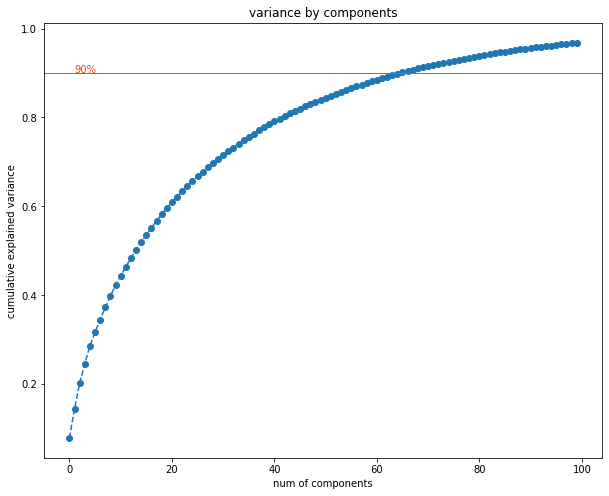

In [45]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA


pca = PCA(k=100, inputCol="scaled", outputCol="features") # here I Have defined maximum number of features that I have
model_pca = pca.fit(df_spark_std) # fit the data to pca to make the model
#print(model_pca.explainedVariance) # here it will explain the variances
cumValues = model_pca.explainedVariance.cumsum() # get the cumulative values

for i in range(100) :
    if cumValues[i]>0.9 :
        print ('sum of explained variances :'+ str(cumValues[i]))
        print ('for k = '+str(i)) 
        break


    
# plot the graph 
plt.figure(figsize=(10,8))
plt.plot(range(0,100), cumValues, marker = 'o', linestyle='--')
plt.title('variance by components')
plt.xlabel('num of components')
plt.ylabel('cumulative explained variance')
plt.axhline(0.9, lw = 1, c = 'orangered')
plt.text(1, 0.9, '90%', c = 'orangered')
plt.show()

In [47]:
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors


pca = PCA(k=65, inputCol="scaled",outputCol="pcaFeatures")
model_pca = pca.fit(df_spark_std)
result = model_pca.transform(df_spark_std).select(["pcaFeatures"])
result.show()


+--------------------+
|         pcaFeatures|
+--------------------+
|[-11.588194011128...|
|[-14.066270039090...|
|[-10.398679887832...|
|[-17.660177898042...|
|[-18.265217005210...|
|[-18.368651450087...|
|[-19.360984020120...|
|[-21.503987330574...|
|[-21.653342370782...|
|[-10.542837265719...|
|[-11.937251204828...|
|[-11.837986722000...|
|[-14.149781180603...|
|[-9.9878800323457...|
|[-9.7129260689631...|
|[-12.563673867114...|
|[-8.2078468651396...|
|[-8.7794450211486...|
|[-8.4975154456611...|
|[-15.349430937945...|
+--------------------+
only showing top 20 rows



### fusion des dataframes

In [89]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window

#add 'sequential' index and join both dataframe to get the final result
result = result.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))

df1 = df1.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))

result.show()
df1.show()

+--------------------+-------+
|         pcaFeatures|row_idx|
+--------------------+-------+
|[-11.588194011128...|      1|
|[-14.066270039090...|      2|
|[-10.398679887832...|      3|
|[-17.660177898042...|      4|
|[-18.265217005210...|      5|
|[-18.368651450087...|      6|
|[-19.360984020120...|      7|
|[-21.503987330574...|      8|
|[-21.653342370782...|      9|
|[-10.542837265719...|     10|
|[-11.937251204828...|     11|
|[-11.837986722000...|     12|
|[-14.149781180603...|     13|
|[-9.9878800323457...|     14|
|[-9.7129260689631...|     15|
|[-12.563673867114...|     16|
|[-8.2078468651396...|     17|
|[-8.7794450211486...|     18|
|[-8.4975154456611...|     19|
|[-15.349430937945...|     20|
+--------------------+-------+
only showing top 20 rows

+--------------------+----------+------------------+-----------+-------+
|                path|    Folder|          Category|      Image|row_idx|
+--------------------+----------+------------------+-----------+-------+
|fruits-360

In [88]:
final_df = df1.join(result, df1.row_idx == result.row_idx).\
             drop("row_idx")
final_df.show()

+--------------------+----------+------------------+-----------+--------------------+
|                path|    Folder|          Category|      Image|         pcaFeatures|
+--------------------+----------+------------------+-----------+--------------------+
|fruits-360/Apple ...|fruits-360|Apple Crimson Snow|  0_100.jpg|[-11.588194011128...|
|fruits-360/Apple ...|fruits-360|Apple Crimson Snow| 10_100.jpg|[-14.066270039090...|
|fruits-360/Apple ...|fruits-360|Apple Crimson Snow|111_100.jpg|[-10.398679887832...|
|fruits-360/Apple ...|fruits-360|    Apple Golden 2|  0_100.jpg|[-17.660177898042...|
|fruits-360/Apple ...|fruits-360|    Apple Golden 2|100_100.jpg|[-18.265217005210...|
|fruits-360/Apple ...|fruits-360|    Apple Golden 2|101_100.jpg|[-18.368651450087...|
|fruits-360/Apple ...|fruits-360|Apple Granny Smith|  0_100.jpg|[-19.360984020120...|
|fruits-360/Apple ...|fruits-360|Apple Granny Smith|100_100.jpg|[-21.503987330574...|
|fruits-360/Apple ...|fruits-360|Apple Granny Smith|10

## Enregistrement du dataframe sur s3

### Création du CSV

In [76]:
# on transforme la colonne au format array "pca features" en string pour pouvoir l'enregistrer au format csv


from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def array_to_string(my_list):
    return '[' + ','.join([str(elem) for elem in my_list]) + ']'

array_to_string_udf = udf(array_to_string, StringType())

final_df_P8 = final_df.withColumn('pcaFeatures_str', array_to_string_udf(final_df["pcaFeatures"]))

In [86]:
# on supprime la colonne au format array

final_df_P8 = final_df_P8.drop("pcaFeatures")
final_df_P8.show()

+--------------------+----------+------------------+-----------+--------------------+
|                path|    Folder|          Category|      Image|     pcaFeatures_str|
+--------------------+----------+------------------+-----------+--------------------+
|fruits-360/Apple ...|fruits-360|Apple Crimson Snow|  0_100.jpg|[-11.588194011128...|
|fruits-360/Apple ...|fruits-360|Apple Crimson Snow| 10_100.jpg|[-14.066270039090...|
|fruits-360/Apple ...|fruits-360|Apple Crimson Snow|111_100.jpg|[-10.398679887832...|
|fruits-360/Apple ...|fruits-360|    Apple Golden 2|  0_100.jpg|[-17.660177898042...|
|fruits-360/Apple ...|fruits-360|    Apple Golden 2|100_100.jpg|[-18.265217005210...|
|fruits-360/Apple ...|fruits-360|    Apple Golden 2|101_100.jpg|[-18.368651450087...|
|fruits-360/Apple ...|fruits-360|Apple Granny Smith|  0_100.jpg|[-19.360984020120...|
|fruits-360/Apple ...|fruits-360|Apple Granny Smith|100_100.jpg|[-21.503987330574...|
|fruits-360/Apple ...|fruits-360|Apple Granny Smith|10

In [79]:
final_df_P8.printSchema()

root
 |-- path: string (nullable = true)
 |-- Folder: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Image: string (nullable = true)
 |-- pcaFeatures_str: string (nullable = true)



In [ ]:
final_df_P8.write.csv('final_df_P8.csv')

### Envoi dans S3

In [84]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('donneesp8v2')
s3.Object('donneesp8v2', 'final_df_P8.csv').put(Body=open('/home/ec2-user/final_df_P8.csv/final_df_P8.csv', 'rb'))

{'ResponseMetadata': {'RequestId': 'CC4M99N0KY3TCC41',
  'HostId': '+w2/XfqtdZXrjjxmYg9Jxqsz+47b3bk3wHEarE2khubv8+i6dTwHFw3ZAEEPKuao45aK3FETahI=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '+w2/XfqtdZXrjjxmYg9Jxqsz+47b3bk3wHEarE2khubv8+i6dTwHFw3ZAEEPKuao45aK3FETahI=',
   'x-amz-request-id': 'CC4M99N0KY3TCC41',
   'date': 'Thu, 10 Feb 2022 17:30:17 GMT',
   'etag': '"08c50c2891439cc187b71dd71c616a52"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 1},
 'ETag': '"08c50c2891439cc187b71dd71c616a52"'}

## Kmeans :

In [90]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='pcaFeatures', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,75):
    
    KMeans_algo=KMeans(featuresCol='pcaFeatures', k=i)
    
    KMeans_fit=KMeans_algo.fit(final_df)
    
    output=KMeans_fit.transform(final_df)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print(i," Silhouette Score:",score)

2  Silhouette Score: 0.14728104674895906
3  Silhouette Score: 0.10788597959188441
4  Silhouette Score: 0.052720470272529414
5  Silhouette Score: 0.0637859818157531
6  Silhouette Score: 0.06750299001743108
7  Silhouette Score: -0.009709576434684558
8  Silhouette Score: 0.047052411047311365
9  Silhouette Score: 0.10274193637382299
10  Silhouette Score: 0.1467086482205821
11  Silhouette Score: 0.1347752767237736
12  Silhouette Score: 0.129039979775723
13  Silhouette Score: 0.10172251647523314
14  Silhouette Score: 0.07116030217359208
15  Silhouette Score: 0.062355929251173364
16  Silhouette Score: 0.16984853207562448
17  Silhouette Score: 0.1303726006588546
18  Silhouette Score: 0.15007809857233947
19  Silhouette Score: 0.19902420502341486
20  Silhouette Score: 0.13037385422083508
21  Silhouette Score: 0.21130193971210068
22  Silhouette Score: 0.20714255383434277
23  Silhouette Score: 0.22879774991238472
24  Silhouette Score: 0.23441160317743628
25  Silhouette Score: 0.2345845057282877
26

Text(0, 0.5, 'cost')

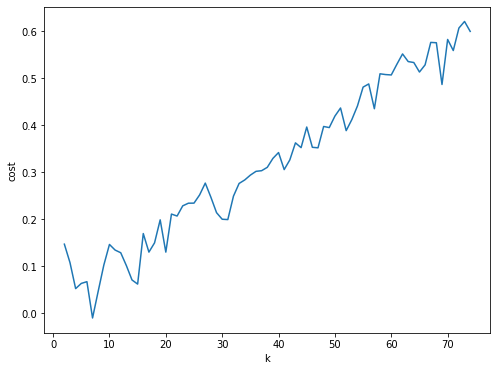

In [62]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,75),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [91]:
KMeans_algo=KMeans(featuresCol='pcaFeatures', k=65)
    
KMeans_fit=KMeans_algo.fit(final_df)
    
output=KMeans_fit.transform(final_df)

output.show()

+--------------------+----------+------------------+-----------+--------------------+----------+
|                path|    Folder|          Category|      Image|         pcaFeatures|prediction|
+--------------------+----------+------------------+-----------+--------------------+----------+
|fruits-360/Apple ...|fruits-360|Apple Crimson Snow|  0_100.jpg|[-11.588194011128...|        24|
|fruits-360/Apple ...|fruits-360|Apple Crimson Snow| 10_100.jpg|[-14.066270039090...|        24|
|fruits-360/Apple ...|fruits-360|Apple Crimson Snow|111_100.jpg|[-10.398679887832...|        55|
|fruits-360/Apple ...|fruits-360|    Apple Golden 2|  0_100.jpg|[-17.660177898042...|        13|
|fruits-360/Apple ...|fruits-360|    Apple Golden 2|100_100.jpg|[-18.265217005210...|        13|
|fruits-360/Apple ...|fruits-360|    Apple Golden 2|101_100.jpg|[-18.368651450087...|        13|
|fruits-360/Apple ...|fruits-360|Apple Granny Smith|  0_100.jpg|[-19.360984020120...|        46|
|fruits-360/Apple ...|fruits-3

In [ ]:
# annexe : 

In [ ]:

#add 'sequential' index and join both dataframe to get the final result
a = a.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
b = b.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))

final_df = a.join(b, a.row_idx == b.row_idx).\
             drop("row_idx")
final_df.show()